In [22]:
import os
import pygmt
import rioxarray
import numpy as np
import xarray as xr
import pandas as pd
from scipy import spatial

import pickle
import rasterio
from rasterio.transform import from_origin

from pysheds.grid import Grid

import matplotlib
import matplotlib.pyplot as plt

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Catchment characteristics

Let's take the last time step

In [23]:
step = 18

# Open netcdf data file for a specific time step
out_path = 'export/'
dataset = xr.open_dataset(out_path+'data'+str(step)+'.nc')

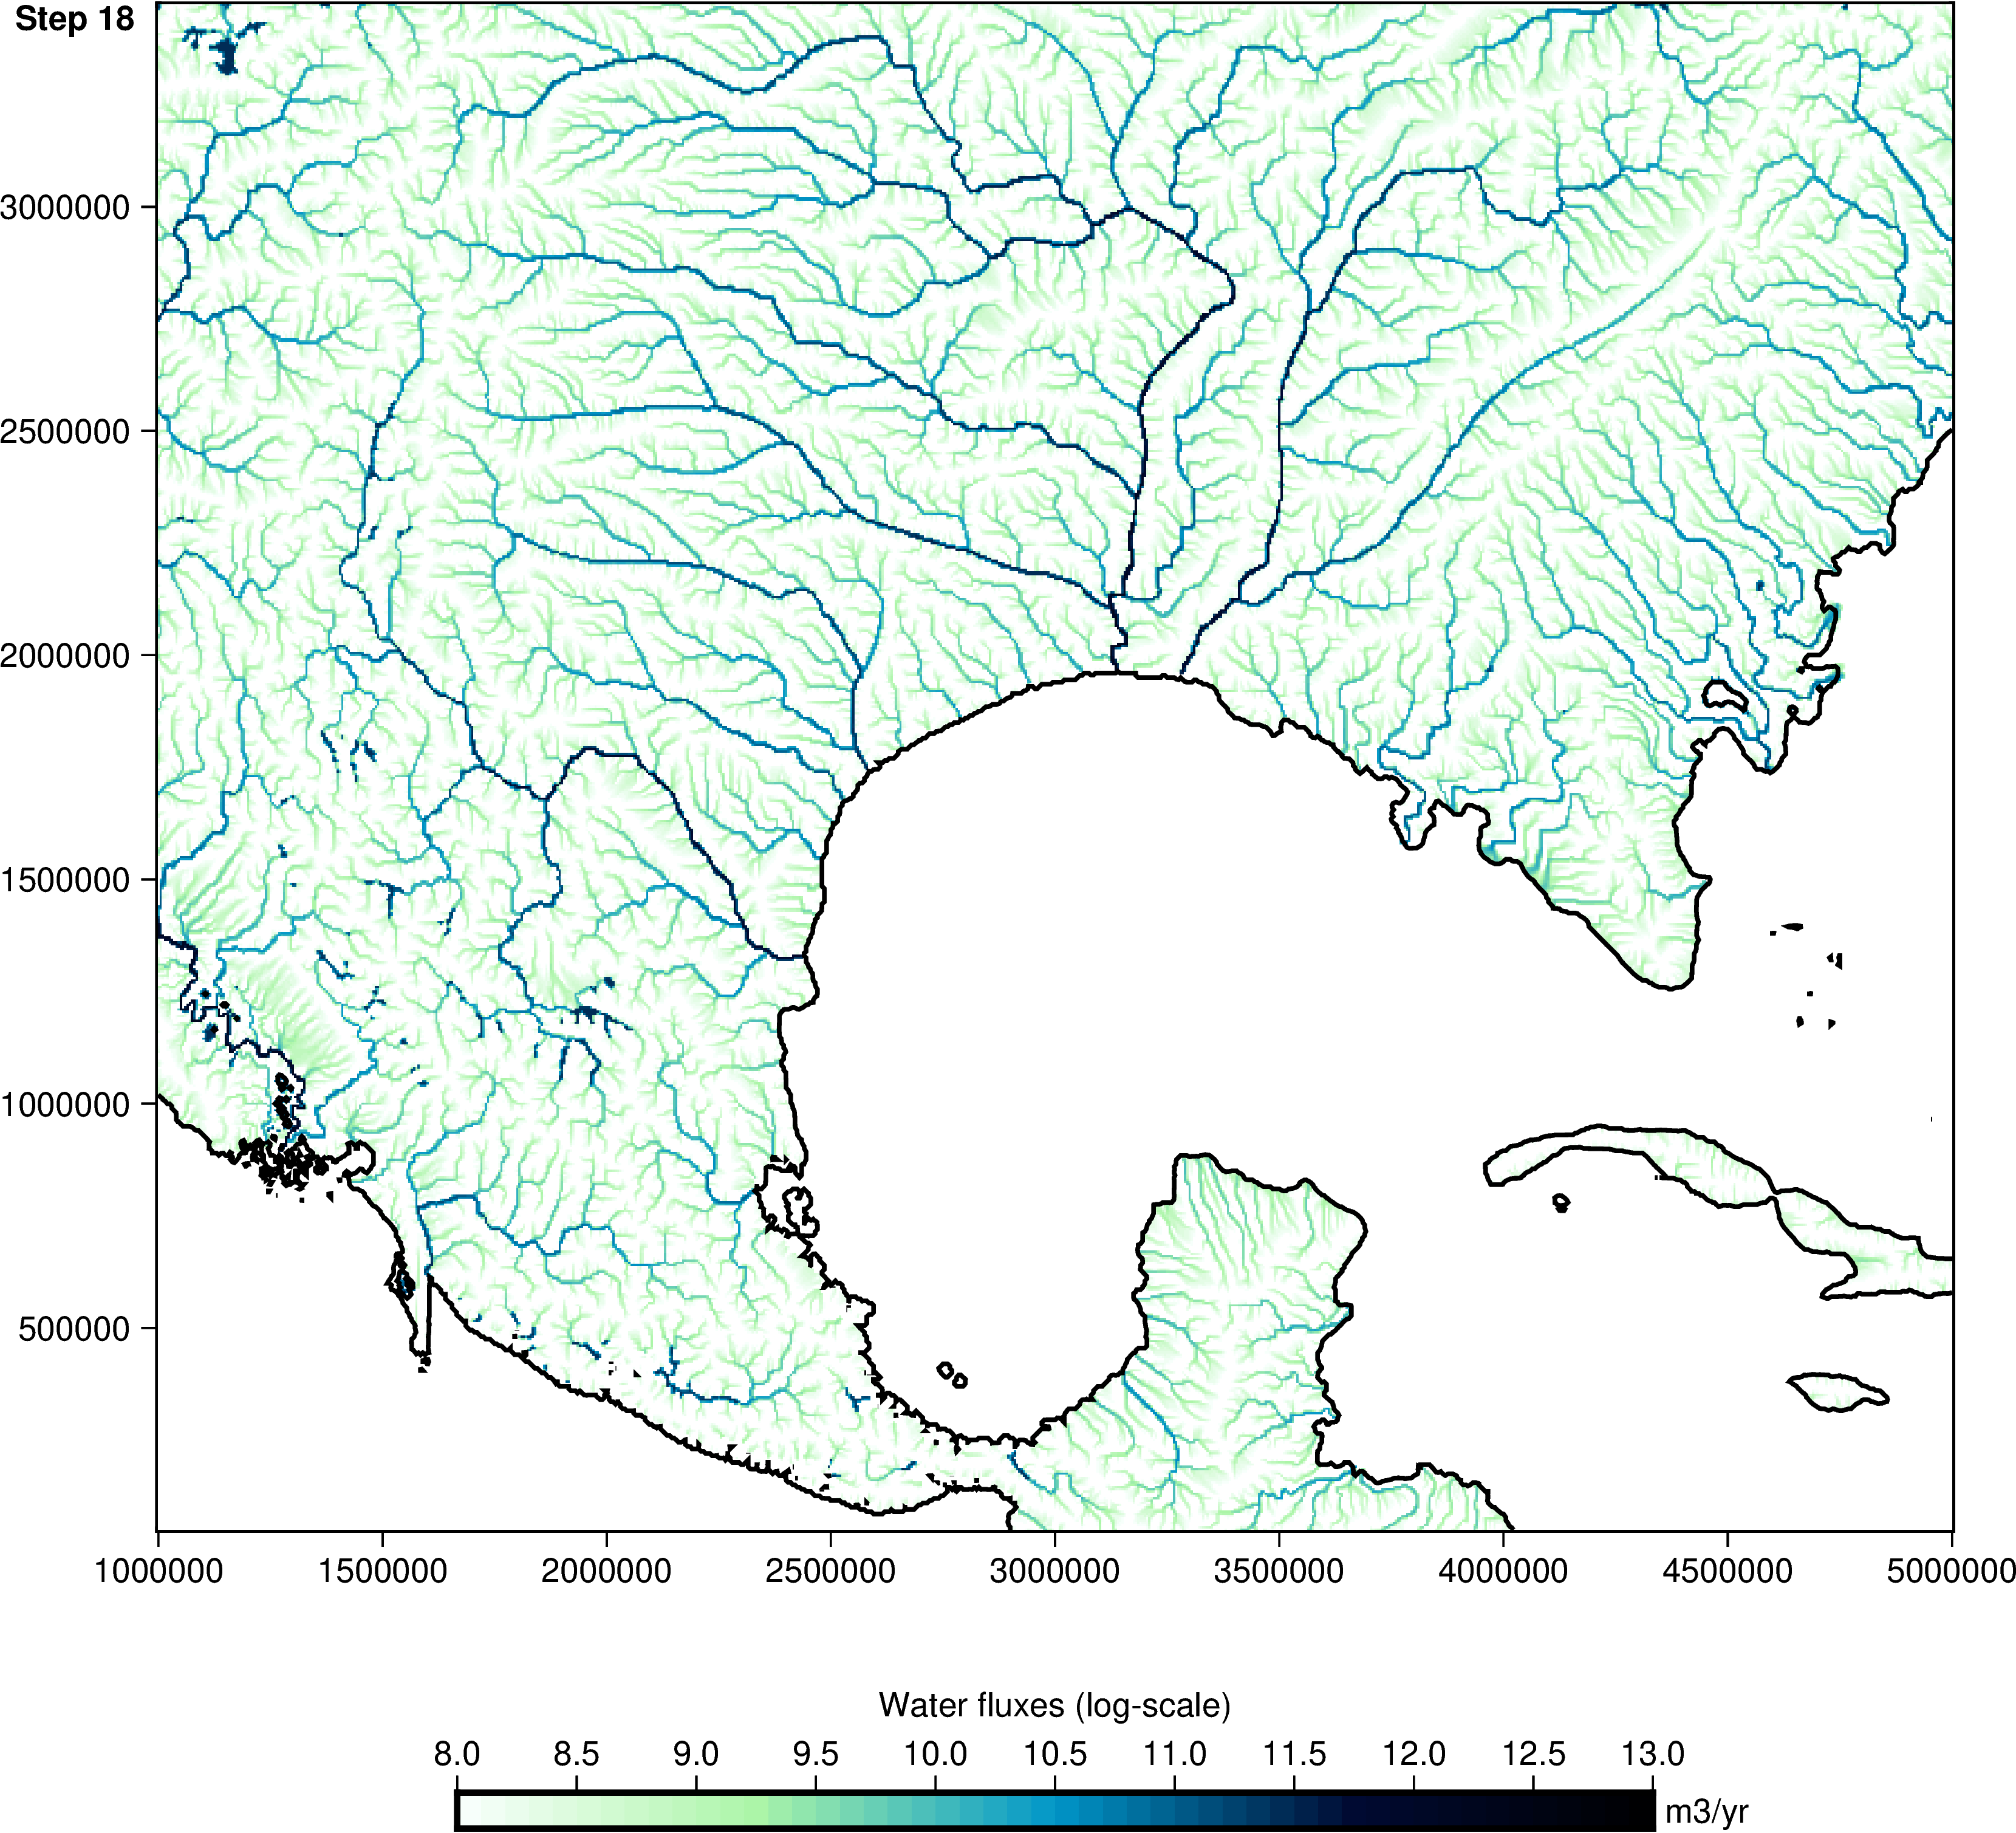

In [24]:
# We will use a log scale here
vals = np.log10(dataset.fillDischarge)

fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(
        cmap="ocean",
        series=[8,13,0.1],
        reverse=True,
    )
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(vals, cmap=True, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a0.5", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")
    
    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=600)

We now create a `geotiff` with the data:

_Note that if you used the approach described in the notebook `2-buildInputs` you can simply do:_

```python
geotiffname = 'view.tif'
dataset.rio.write_crs(32615, inplace=True) # where 32615 should be replaced by the value of epsg in notebook 2
dataset['elevation'].rio.to_raster(geotiffname)
```

In [25]:
# We need to flip the elevation array (not sure why)
dataset['elev'] = (['y', 'x'],  np.flipud(dataset.elevation.values))

# Taking the last time step of the elevation array
elevArray = dataset.elev

# Assigning a value of -9999.0 to all point below sea-level
elevArray = elevArray.where(elevArray>0, other=-9999.0)

x = dataset.x.values
y = dataset.y.values
dx = dataset.x.values[1]-dataset.x.values[0]

transform = from_origin(x.min(), y.max(), dx, dx)

new_dataset = rasterio.open(geotiffname, 'w', driver='GTiff',
                            height = elevArray.shape[0], width = elevArray.shape[1],
                            count=1, dtype=str(elevArray.dtype),
                            crs='+proj=utm +zone=30 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                            transform=transform)
new_dataset.write(elevArray, 1)
new_dataset.close()

## Extraction of geomorphometrics

We use the pysheds library that reads the geotiff we just created and compute some morphometrics

In [26]:
tifout = os.path.join(geotiffname)

grid = Grid.from_raster(tifout, data_name='dem')
dem = grid.view('dem', nodata=-9999.0)
# dem[dem == -9999] = np.nan

# Compute the depressions
grid.fill_depressions('dem', out_name='filled',
                      nodata_in = -9999, nodata_out = -9999)
filled = grid.view('filled', nodata = -9999).astype(np.float32)

# Resolve flat areas
grid.resolve_flats(data='filled', out_name='demnoflat',
                   nodata_in = -9999, nodata_out = -9999)
demnoflat = grid.view('demnoflat', nodata = -9999).astype(np.float32)
dataset['fill'] = (['y', 'x'],  np.flipud(demnoflat - dem))

# Compute the flow direction
dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
grid.flowdir('demnoflat', out_name='d8', dirmap=dirmap,
             nodata_in = -9999, nodata_out = -9999, pits = -9999, flats = -9999)
d8 = grid.view('d8', nodata = -9999).astype(np.float32)
dataset['flowdir'] = (['y', 'x'],  np.flipud(d8))

# Compute the flow accumulation
grid.accumulation(data='d8', out_name='flowd8')
flowd8 = grid.view('flowd8', nodata = -9999).astype(np.float32)
flowd8[d8 == -9999] = -9999
dataset['flowd8'] = (['y', 'x'],  np.flipud(flowd8))

### Plotting some of the newly created dataset

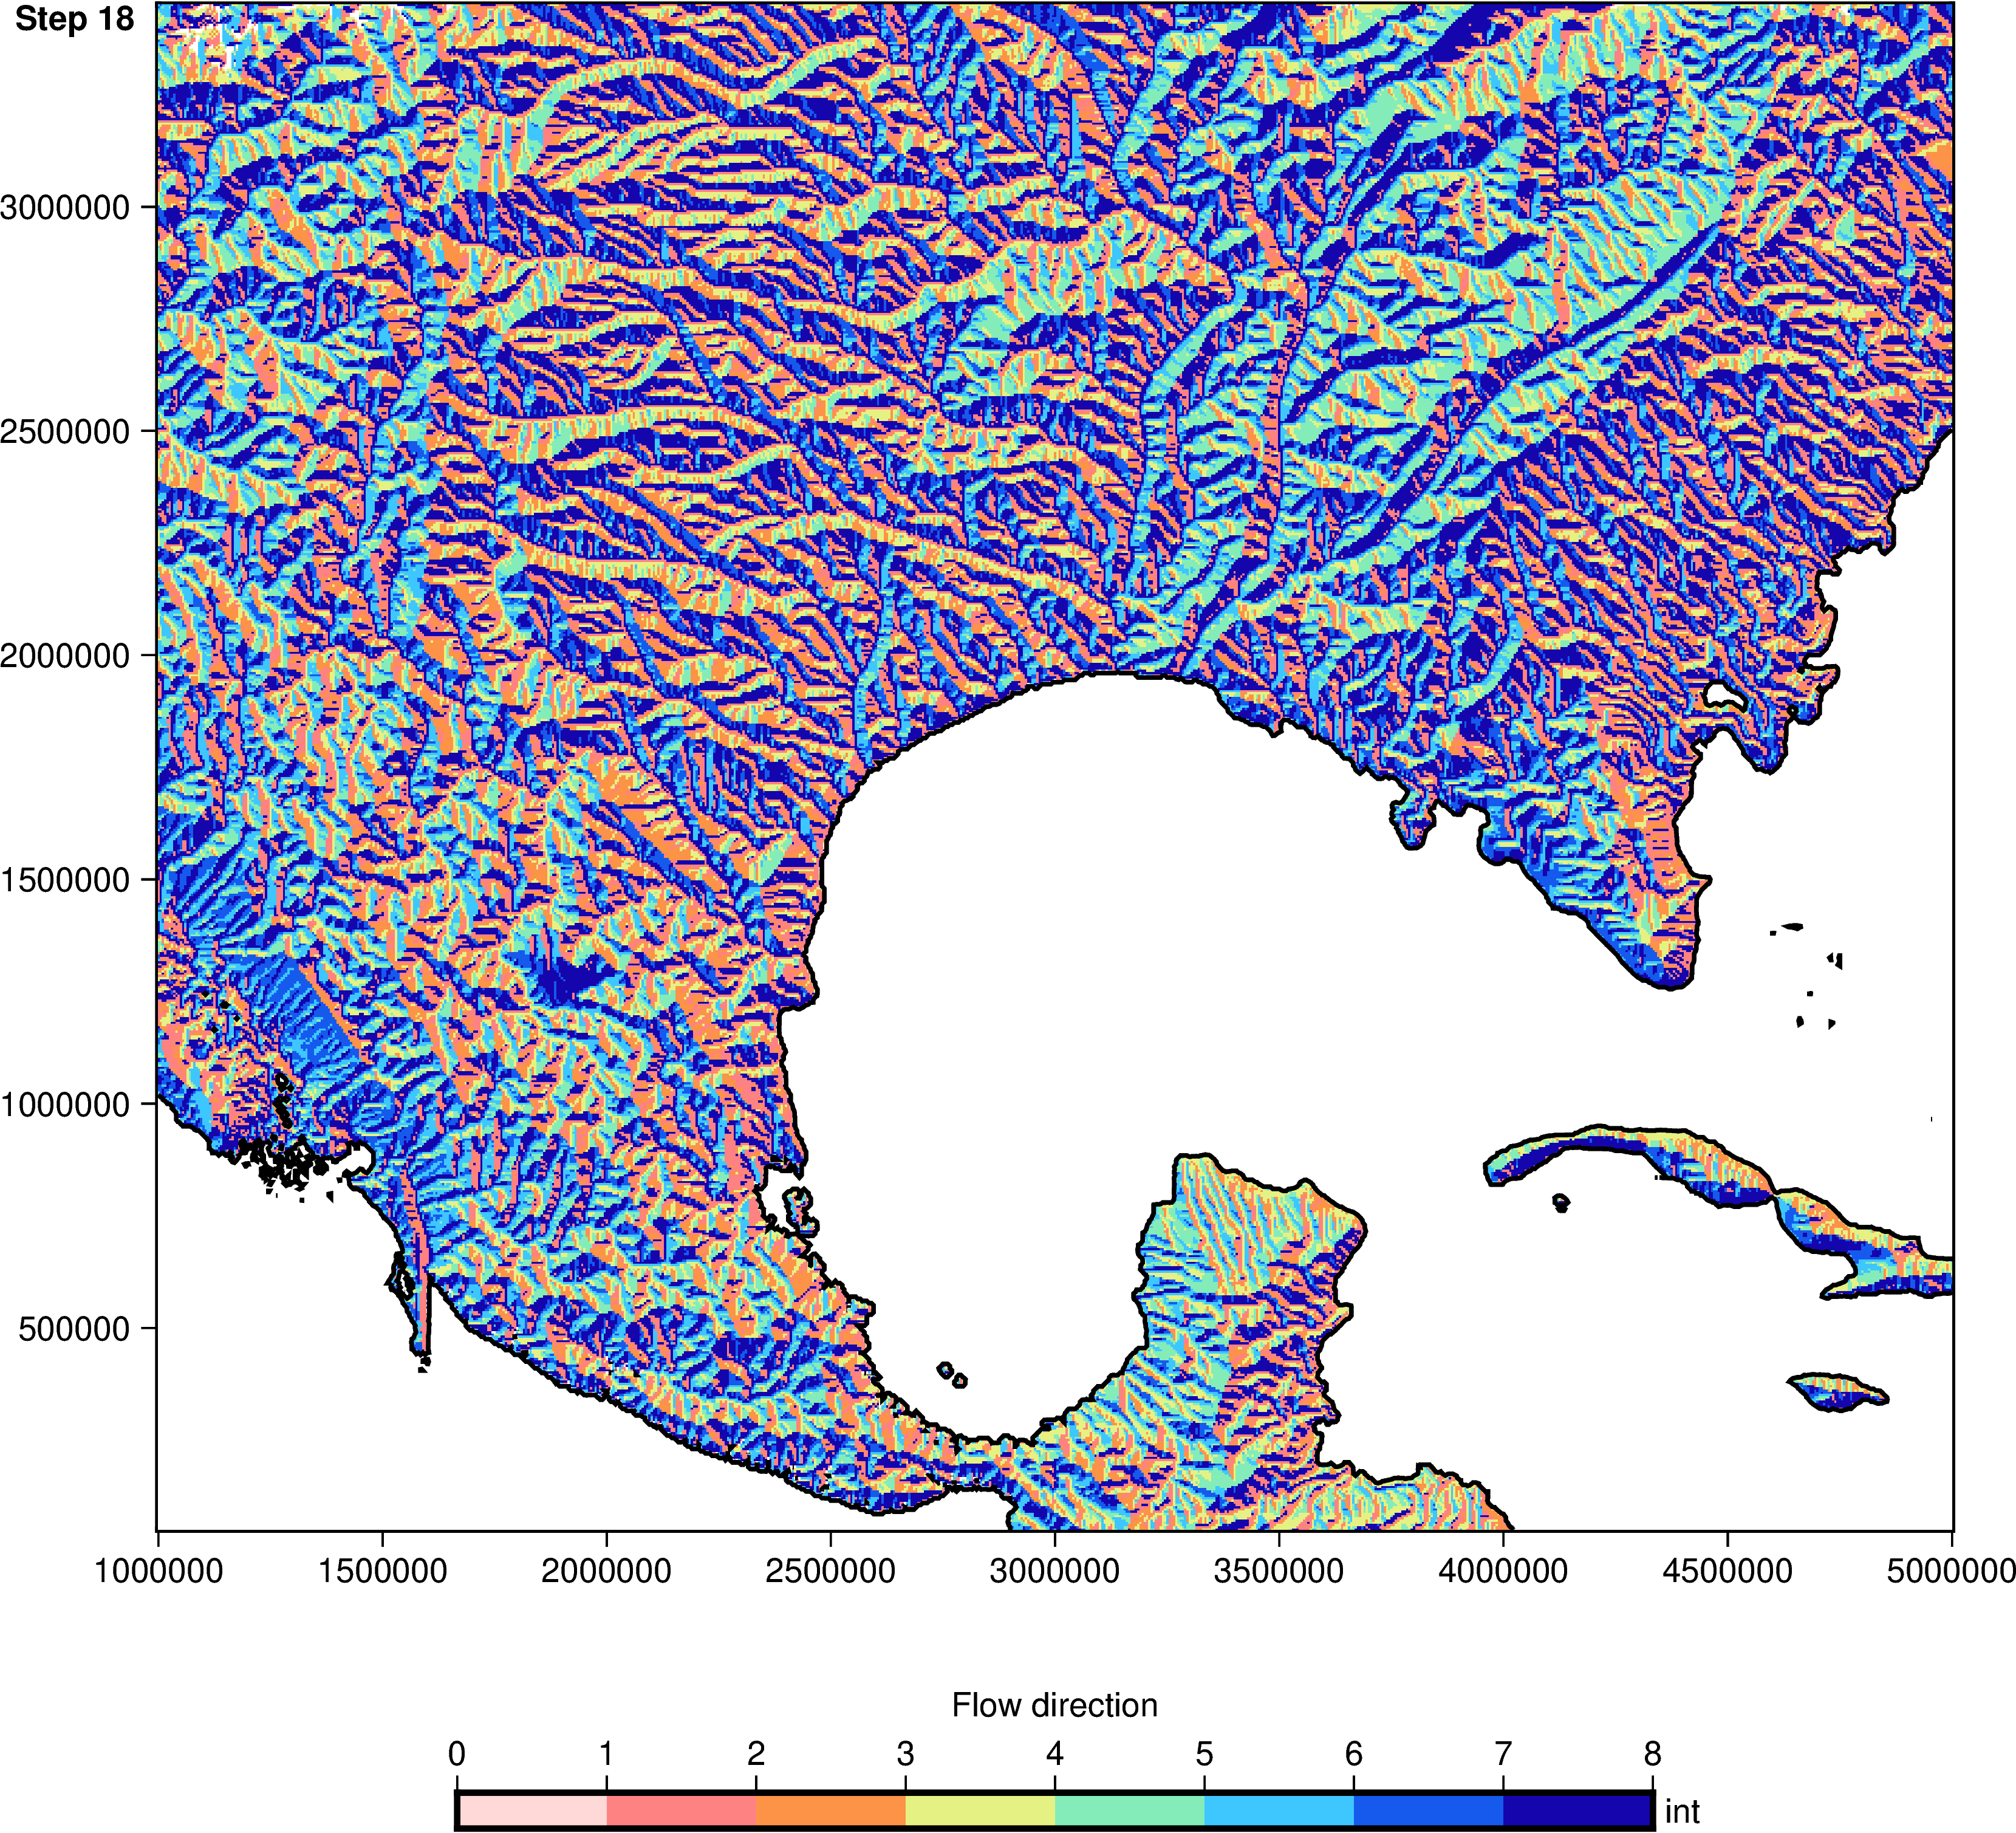

In [27]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(
        cmap="haxby",
        series=[0,8,1],
        reverse=True,
    )
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(dataset['flowdir'], cmap=True, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a1", 'x+l"Flow direction"', "y+lint"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")
    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=600)

In [28]:
# fig = pygmt.Figure()
# with pygmt.config(FONT='8p,Helvetica,black'):
#     pygmt.makecpt(
#         cmap="gray",
#         series=[0,50],
#         reverse=True,
#     )
    
#     fig.basemap(
#         region=[1.e6,5.e6,5e4,3.45e6],
#         frame=['a'],
#         projection="X15c/12.75c",
#     )
#     fig.grdimage(dataset['fill'], cmap=True, shading=False, frame=False)
#     fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
#     fig.colorbar(frame=["a5", 'x+l"Filled elevation"', "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

#     # Customising the font style
#     fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
# fig.show(dpi=500, width=600)

In [29]:
# We will use a log scale here
# vals = np.log10(dataset.flowd8)

# fig = pygmt.Figure()
# with pygmt.config(FONT='8p,Helvetica,black'):
#     pygmt.makecpt(
#         cmap="ocean",
#         series=[1,5,0.1],
#         reverse=True,
#     )
    
#     fig.basemap(
#         region=[1.e6,5.e6,5e4,3.45e6],
#         frame=['a'],
#         projection="X15c/12.75c",
#     )
#     fig.grdimage(vals, cmap=True, shading=False, frame=False)
#     fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
#     fig.colorbar(frame=["a0.5", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")
    
# #     fig.plot(x=x1, y=y1, style="c0.3c", color="red", pen="black")
    
#     # Customising the font style
#     fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
# fig.show(dpi=500, width=600)

## Picking a specific basin

Now let's find the catchment ID corresponding to a specific coordinate.

To extract specific catchments, `pysheds` requires the position of the outlet.
Here we show how to extract a specific outlet based on the flow accumulation values.

In [30]:
nearest_point = dataset.sel(x=3.6e6, y=2.5e6, method="nearest")
basin = dataset.where(dataset.basinID==nearest_point.basinID.values, drop=True)
basin0 = basin.fillna(0)
outlet = basin0.where(basin0.flowd8==basin0.flowd8.values.max(), drop=True)
outletX = outlet.x.values
outletY = outlet.y.values
print('Basin ID: ',nearest_point.basinID.values)

Basin ID:  5833


Let’s see where this outlet is:

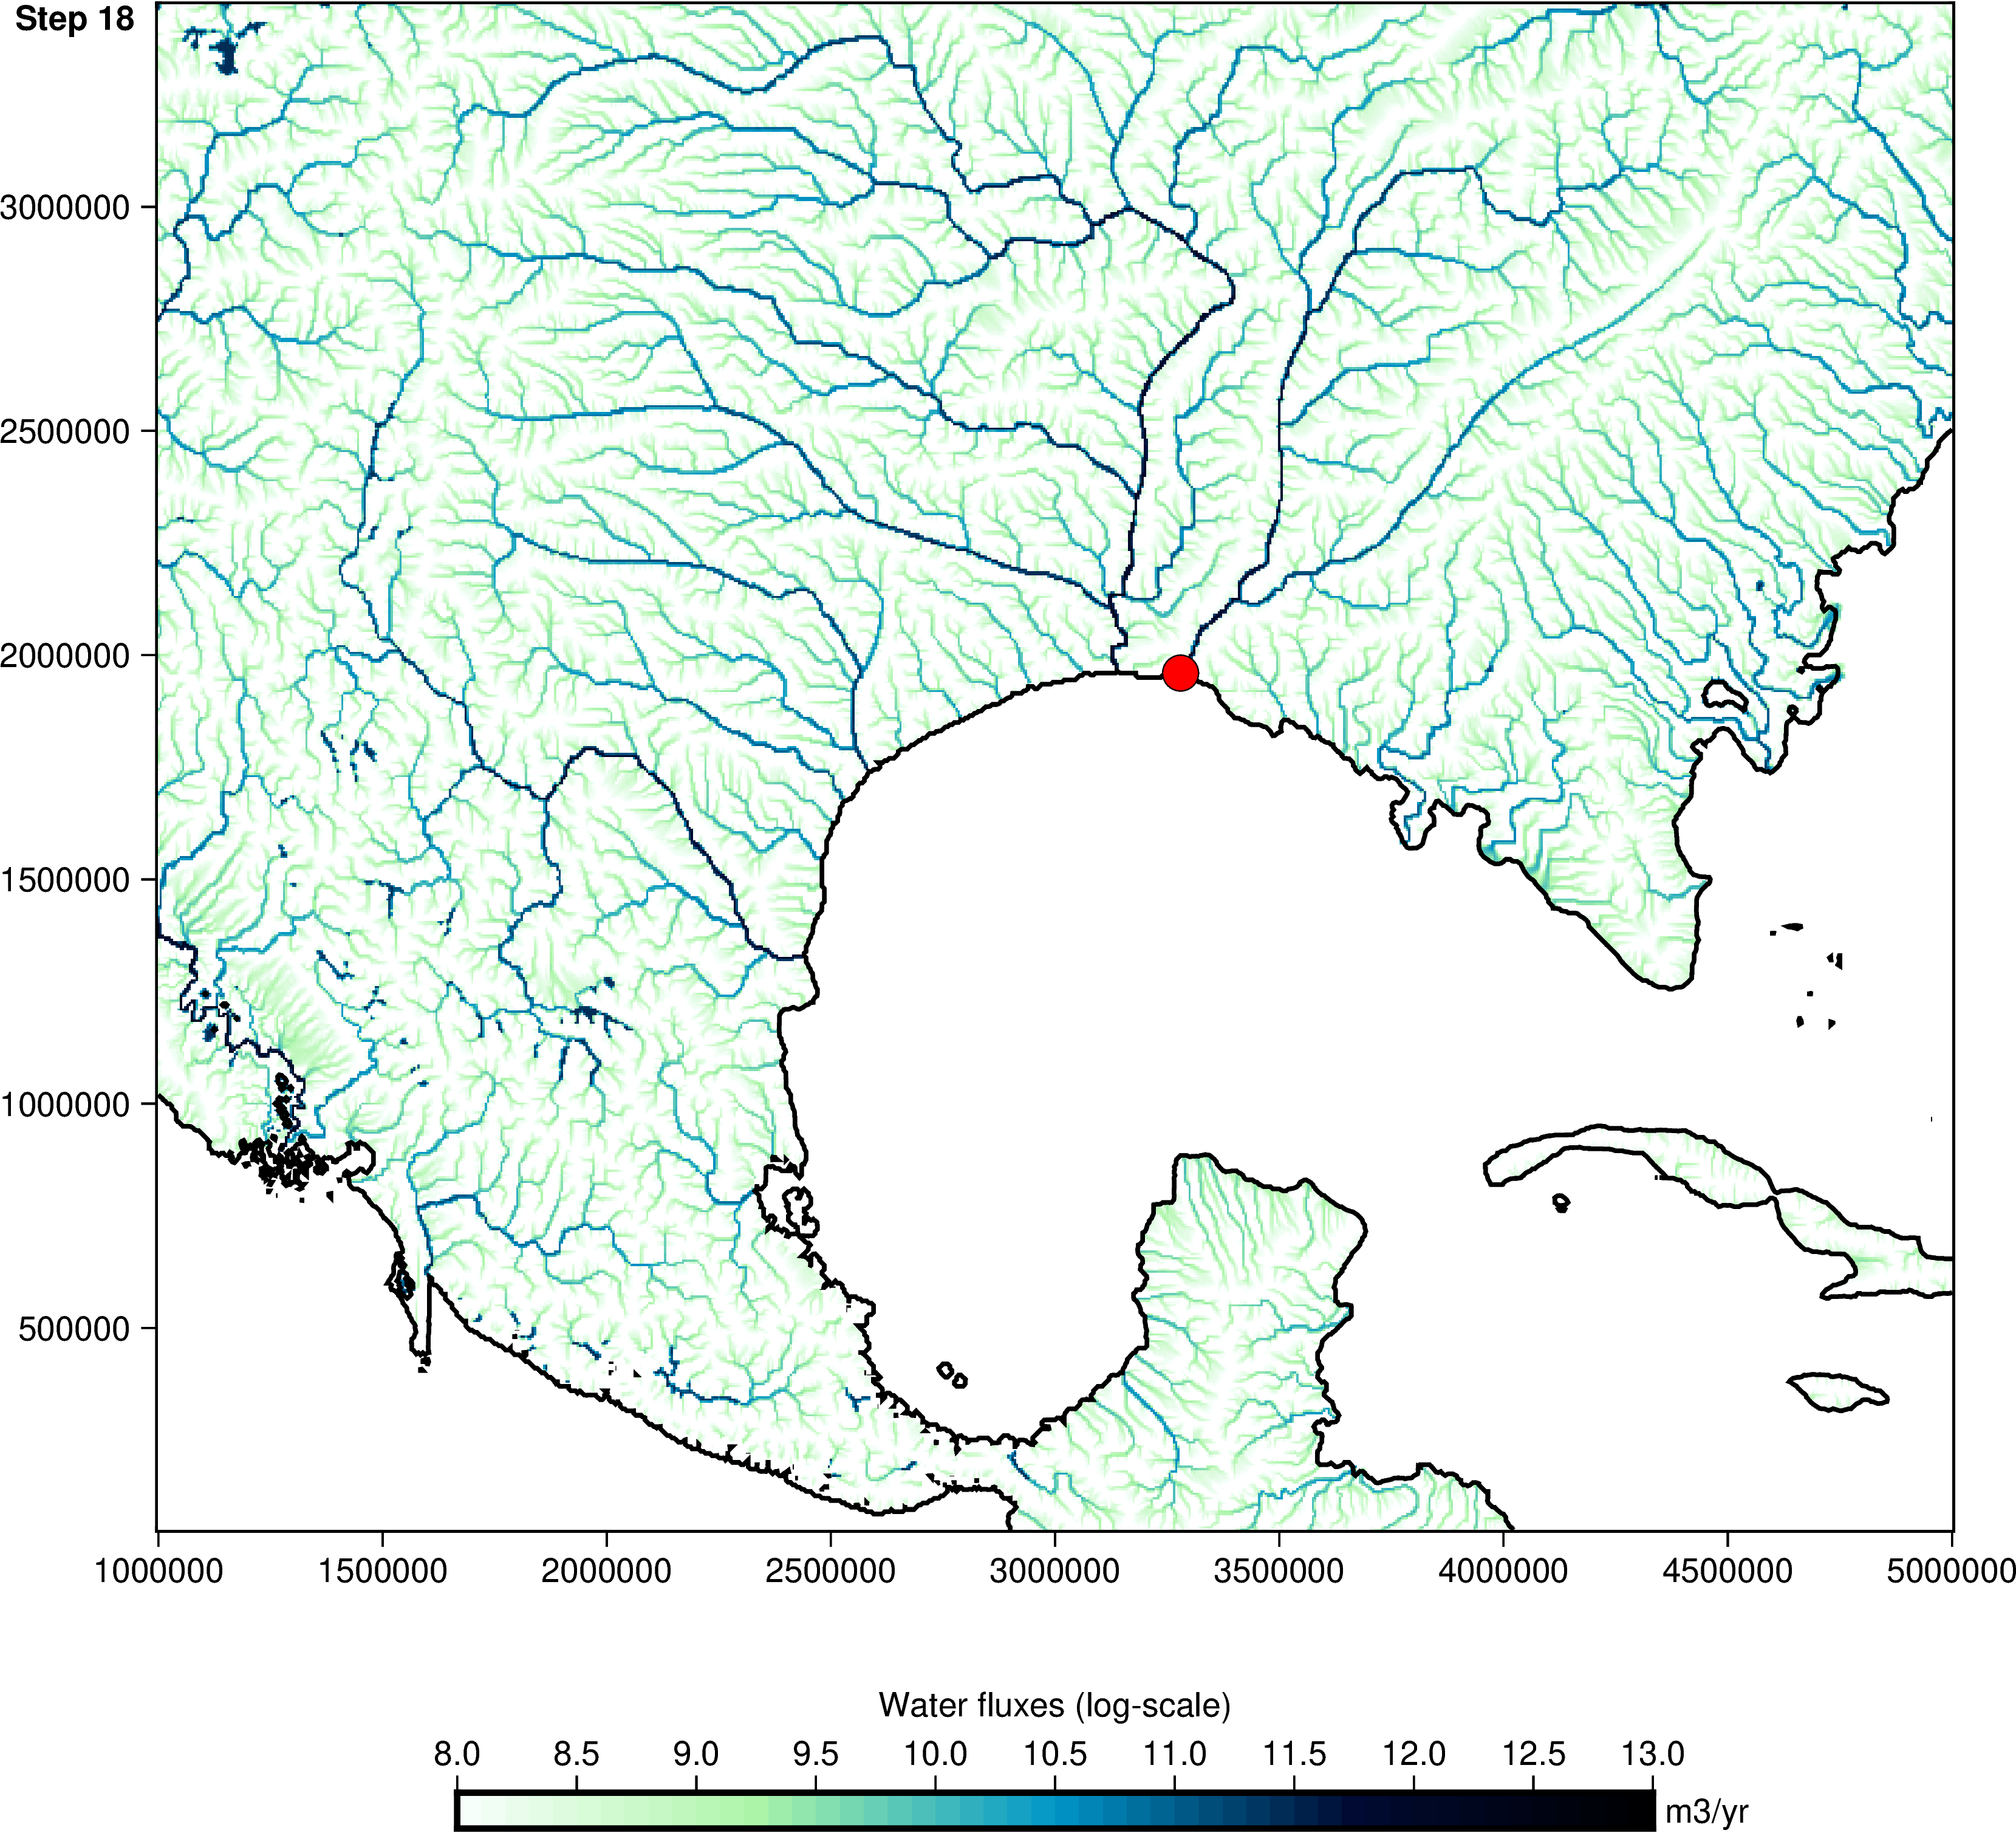

In [31]:
# We will use a log scale here
vals = np.log10(dataset.fillDischarge)

fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(
        cmap="ocean",
        series=[8,13,0.1],
        reverse=True,
    )
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(vals, cmap=True, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a0.5", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")
    
    fig.plot(x=outletX, y=outletY, style="c0.3c", color="red", pen="black")
    
    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=600)

In [32]:
# Find the point ID corresponding to the maximum flow accumulation value
outletID = np.where(flowd8.flatten() == flowd8.max())[0]

# Get the corresponding point coordinate
outletPt = dem.coords[outletID,:][0]

# Define this first outlet by x1,y1
x1, y1 = outletPt[1], outletPt[0]

## Get corresponding catchments

We now define a function getCatchment which extract river network (up to a specified flow accumulation threshold).

In [33]:
def getCatchment(geotiff, x, y, threshold):
    '''
    Extract a specific river network based on outlet position and flow accumulation threshold.
    '''
    
    grd = Grid.from_raster(geotiff, data_name='dem')

    grd.fill_depressions('dem', out_name='filled',
                          nodata_in = -9999, nodata_out = -9999)
    grd.resolve_flats(data='filled', out_name='inflated_dem')

    dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
    grd.flowdir('inflated_dem', out_name='dir', dirmap=dirmap,
                  nodata_in = -9999, nodata_out = -9999, 
                  pits = -9999, flats = -9999)
    
    grd.accumulation(data='dir', out_name='acc2')

    acc2 = grd.view('acc2', nodata = -9999).astype(np.float32)
    acc2[acc2==0] = -9999
    
    grd.catchment(data='dir', x=x, y=y, out_name='catch',
                    recursionlimit=15000, xytype='label')

    
    grd.clip_to('catch', pad=(1,1,1,1))

    grd.accumulation(data='catch', out_name='acc')
    
    acc = grd.view('acc', nodata = -9999).astype(np.float32)
    acc[acc==0] = -9999
    
    branches = grd.extract_river_network('catch', 'acc', dirmap=dirmap, threshold=threshold, 
                                       nodata_in=-9999, routing='d8',
                                       apply_mask=True)
    
    data = np.ma.masked_array(acc, mask = (acc <= -9999))
    
#     plt.figure(figsize=(5,5))
#     ax = plt.gca()
#     im = plt.imshow(data, extent=grd.extent, cmap='Blues', vmin=0, vmax=np.max(acc)/100)
#     plt.plot(x, y, 'o', color='r', markersize=10, markeredgecolor='k', markeredgewidth=1)
#     plt.colorbar(im, label='flow accumulation', shrink=0.5)
#     plt.grid()
#     plt.tight_layout()
#     plt.show()
    
    tree = spatial.cKDTree(dem.coords, leafsize=10)
    
    branch_df = []
    nbbranches = len(branches['features'])
    
    for b in range(nbbranches):
        branch = branches['features'][b]
        branchXY = np.asarray(branch['geometry']['coordinates'])
        branchXY = np.flip(branchXY,1)
        dist, id = tree.query(branchXY, k=1)
        elev = demnoflat.flatten()[id]
        fa = acc2.flatten()[id]

        data = np.vstack((branchXY[:,0], branchXY[:,1], 
                          elev, fa))
        df = pd.DataFrame(data.T,
                          columns = ['x','y','elev','fa'])
        df = df[df.fa > -9999]
        df = df.reset_index(drop=True)

        xx = df.x.to_numpy()
        yy = df.y.to_numpy()
        dx = xx[1:]-xx[:-1]
        dy = yy[1:]-yy[:-1]
        step_size = np.sqrt(dx**2+dy**2)
        cumulative_distance = np.concatenate(([0], np.cumsum(step_size)))
        df['dist'] = cumulative_distance

        branch_df.append(df)
        
    
    endbranch = None
    maxfa = -10000
    for b in range(nbbranches):
        if branch_df[b].fa[0] > maxfa:
            maxfa = branch_df[b].fa[0]
            endbranch = b
            
    newdf = []
    newdf.append(branch_df[endbranch])
    for b in range(nbbranches):
        if b != endbranch:
            newdf.append(branch_df[b])
        
    return branches, newdf

We call the function for the outlet that was defined previously. The function returns 2 variables:

a dictionnary containing the geometry and coordinates of the main rivers
a pandas dataframe containing for each river the associated flow and elevation information

In [34]:
branches1, bdf1 = getCatchment(geotiff=tifout, x=outletX, y=outletY, threshold=500)

## Plotting river networks

The river networks can be obtained directly from the previous function first variable:

In [35]:
def plotBranch(branchnb):

    plt.figure(figsize=(7,7))
    ax = plt.gca()

    for branch in branchnb['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        plt.plot(line[:, 0], line[:, 1], lw=3)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return

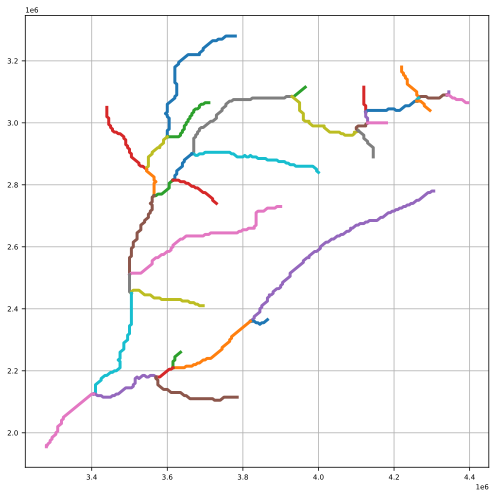

In [36]:
plotBranch(branches1)

## Longitudinal profiles

The second variable can be used to extract river longitudinal profile. To do so we define a new function combineBranch which connect each individual trunk together:

In [37]:
def combineBranch(branch_df):
    
    check = True
    
    pp = 0
    nbbranches = len(branch_df)
    while(check):
        for b in range(0,nbbranches):
            row1 = branch_df[b].iloc[0]
            x1, y1, dist1 = row1.x, row1.y, row1.dist

            lastrow = np.array(branch_df[b].tail(1))[0]
            xend, yend, distend = lastrow[0], lastrow[1], lastrow[-1]

            for nextb in range(0,nbbranches):
                if nextb != b:
                    firstrow = branch_df[nextb].iloc[0]
                    xstart, ystart, diststart = firstrow.x, firstrow.y, firstrow.dist
                    changed = False
                    if diststart == 0:
                        if abs(xstart-xend) < 1. and abs(ystart-yend) < 1.0:
                            if b == 0:
                                branch_df[nextb].dist += distend
                                changed = True
                            else:
                                if dist1 > 0.:
                                    branch_df[nextb].dist += distend
                                    changed = True
                        if not changed:
                            if abs(xstart-x1) < 1. and abs(ystart-y1) < 1.0:
                                if b == 0:
                                    branch_df[nextb].dist += 0.0001
                                else:
                                    branch_df[nextb].dist += dist1            
        
        check = False
        for b in range(1,nbbranches):
            if branch_df[b].iloc[0].dist == 0.:
                check = True
                
        
    return branch_df

In [38]:
ndf1 = combineBranch(branch_df=bdf1)

In [39]:
def plotProfile(dataframe):
    '''
    Function for plotting the longitudinal profile.
    '''

    plt.figure(figsize=(10,5))
    ax = plt.gca()

    for branch in range(len(dataframe)-1,-1,-1):
        distance = np.asarray(dataframe[branch].dist)
        elev = np.asarray(dataframe[branch].elev)
        plt.plot(distance, elev, lw=3)
        
    plt.tight_layout()
    plt.show()
    
    return

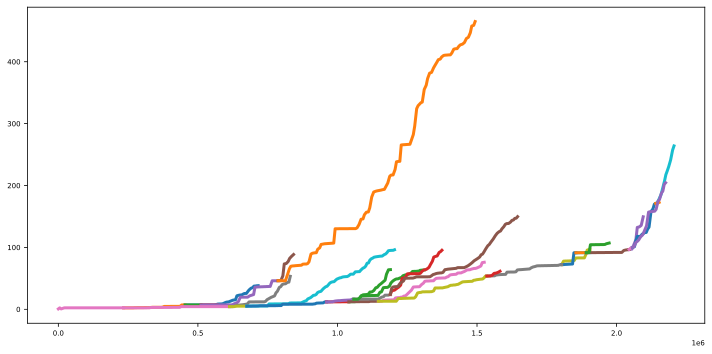

In [40]:
plotProfile(ndf1)

## Save dataset

In [20]:
with open('profile.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(ndf1, filehandle)

In [21]:
with open('branchesXY.data', 'wb') as f:
    pickle.dump(branches1, f)